In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import os
import cv2
import json
import numpy as np
from sklearn.model_selection import train_test_split

# =========================
# CONFIG
# =========================
DATA_DIR = "quickdraw_images_dedup"
MAX_PER_CLASS = None
TEST_SPLIT = 0.15
VAL_SPLIT = 0.15
SEED = 42

np.random.seed(SEED)

# =========================
# DISCOVER CLASSES
# =========================
class_names = sorted([
    d for d in os.listdir(DATA_DIR)
    if os.path.isdir(os.path.join(DATA_DIR, d))
])

class_to_idx = {cls: i for i, cls in enumerate(class_names)}

print(f"[INFO] Found {len(class_names)} classes")

# =========================
# LOAD RAW DATA (NO PREPROCESSING)
# =========================
X = []   # raw grayscale images
y = []   # labels

for cls in class_names:
    cls_path = os.path.join(DATA_DIR, cls)
    label = class_to_idx[cls]

    files = os.listdir(cls_path)
    np.random.shuffle(files)
    files = files[:MAX_PER_CLASS]

    for fname in files:
        fpath = os.path.join(cls_path, fname)

        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        X.append(img)
        y.append(label)

X = np.array(X, dtype=object)
y = np.array(y)

print(f"[INFO] Total samples loaded: {len(X)}")

# =========================
# TRAIN / VAL / TEST SPLIT
# =========================
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=TEST_SPLIT + VAL_SPLIT,
    stratify=y,
    random_state=SEED
)

val_ratio = VAL_SPLIT / (TEST_SPLIT + VAL_SPLIT)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=val_ratio,
    stratify=y_temp,
    random_state=SEED
)

print("[INFO] Split summary:")
print("  Train:", len(X_train))
print("  Val  :", len(X_val))
print("  Test :", len(X_test))

# =========================
# SAVE CLASS MAP
# =========================
with open("class_map.json", "w") as f:
    json.dump(class_to_idx, f, indent=2)

print("[INFO] Data loading stage complete")

[INFO] Found 33 classes
[INFO] Total samples loaded: 33000
[INFO] Split summary:
  Train: 23100
  Val  : 4950
  Test : 4950
[INFO] Data loading stage complete


In [ ]:
import cv2
import numpy as np
import random

IMG_SIZE = 224

def preprocess_image(img, size=IMG_SIZE, augment=False):
    if img is None:
        return np.zeros((size, size), dtype=np.uint8)

    img = np.asarray(img, dtype=np.uint8)

    # =========================
    # 1) Resize (reference frame)
    # =========================
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)

    # =========================
    # 2) STABLE AUGMENTATION
    # =========================
    if augment:
        h, w = img.shape

        angle = random.uniform(-8, 8)
        scale = random.uniform(0.95, 1.05)
        tx = random.uniform(-0.05, 0.05) * w
        ty = random.uniform(-0.05, 0.05) * h

        M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, scale)
        M[0, 2] += tx
        M[1, 2] += ty

        img = cv2.warpAffine(
            img, M, (w, h),
            flags=cv2.INTER_LINEAR,
            borderValue=0
        )

        if random.random() < 0.25:
            k = 2
            kernel = np.ones((k, k), np.uint8)
            img = cv2.dilate(img, kernel, iterations=1)

        if random.random() < 0.25:
            noise = np.random.normal(0, 3, img.shape)
            img = np.clip(img.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    # =========================
    # 3) Light blur
    # =========================
    img = cv2.GaussianBlur(img, (3, 3), 0)

    # =========================
    # 4) Contrast normalize
    # =========================
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

    # =========================
    # 5) Robust centering
    # =========================
    ys, xs = np.where(img > 15)  # threshold avoids noise jitter
    if len(xs) > 0 and len(ys) > 0:
        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()

        cropped = img[y_min:y_max+1, x_min:x_max+1]

        h, w = cropped.shape
        pad = max(h, w)

        canvas = np.zeros((pad, pad), dtype=np.uint8)
        y_off = (pad - h) // 2
        x_off = (pad - w) // 2
        canvas[y_off:y_off+h, x_off:x_off+w] = cropped

        img = cv2.resize(canvas, (size, size), interpolation=cv2.INTER_AREA)

    return img


In [46]:
def preprocess_batch(X, augment=False):
    return np.array(
        [preprocess_image(img, augment=augment) for img in X],
        dtype=np.uint8
    )


In [47]:
X_train_pp = preprocess_batch(X_train, augment=True)
X_val_pp   = preprocess_batch(X_val, augment=True)
X_test_pp  = preprocess_batch(X_test, augment=False)

print("[INFO] Preprocessing complete")
print("Train:", X_train_pp.shape)
print("Val  :", X_val_pp.shape)
print("Test :", X_test_pp.shape)

[INFO] Preprocessing complete
Train: (23100, 224, 224)
Val  : (4950, 224, 224)
Test : (4950, 224, 224)


In [48]:
import numpy as np
import cv2


#HOG
def gradient_orientation_histogram(img, num_bins=9):
    # Sobel gradients
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)

    magnitude = np.sqrt(gx**2 + gy**2)
    angle = (np.arctan2(gy, gx) * 180 / np.pi) % 180

    bin_width = 180 / num_bins
    hist = np.zeros(num_bins, dtype=np.float32)

    for i in range(num_bins):
        mask = (angle >= i * bin_width) & (angle < (i + 1) * bin_width)
        hist[i] = np.sum(magnitude[mask])

    hist /= (np.linalg.norm(hist) + 1e-6)
    return hist


In [49]:
def grid_density(img, grid=7):
    h, w = img.shape
    gh, gw = h // grid, w // grid

    features = []

    for i in range(grid):
        for j in range(grid):
            cell = img[i*gh:(i+1)*gh, j*gw:(j+1)*gw]
            density = np.mean(cell > 0)
            features.append(density)

    return np.array(features, dtype=np.float32)


In [50]:
def gradient_magnitude_stats(img):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)

    mag = np.sqrt(gx**2 + gy**2)

    stats = [
        np.mean(mag),
        np.std(mag),
        np.max(mag),
        np.percentile(mag, 75)
    ]

    return np.array(stats, dtype=np.float32)


In [51]:
def contour_features(img):
    _, bin_img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(
        bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    if len(contours) == 0:
        return np.zeros(5, dtype=np.float32)

    cnt = max(contours, key=cv2.contourArea)

    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    bbox = cv2.boundingRect(cnt)
    aspect_ratio = bbox[2] / (bbox[3] + 1e-6)
    compactness = (perimeter**2) / (area + 1e-6)

    return np.array([
        area,
        perimeter,
        aspect_ratio,
        compactness,
        len(cnt)
    ], dtype=np.float32)


In [52]:
def raw_moment_features(img):
    m = cv2.moments(img)
    feats = [
        m["m00"],
        m["m10"] / (m["m00"] + 1e-6),
        m["m01"] / (m["m00"] + 1e-6),
        m["mu20"],
        m["mu02"],
        m["mu11"]
    ]
    return np.array(feats, dtype=np.float32)


In [53]:
def stroke_transition_features(img):
    img_bin = (img > 0).astype(np.uint8)

    # horizontal transitions
    h_trans = np.sum(img_bin[:, 1:] != img_bin[:, :-1])

    # vertical transitions
    v_trans = np.sum(img_bin[1:, :] != img_bin[:-1, :])

    # diagonal transitions
    d1 = np.sum(img_bin[1:, 1:] != img_bin[:-1, :-1])
    d2 = np.sum(img_bin[1:, :-1] != img_bin[:-1, 1:])

    return np.array([
        h_trans,
        v_trans,
        d1,
        d2
    ], dtype=np.float32)


In [54]:
def normalized_moment_features(img):
    img = img.astype(np.float32)
    total = img.sum() + 1e-6

    y, x = np.indices(img.shape)
    x_bar = (x * img).sum() / total
    y_bar = (y * img).sum() / total

    mu20 = ((x - x_bar)**2 * img).sum() / total
    mu02 = ((y - y_bar)**2 * img).sum() / total
    mu11 = ((x - x_bar)*(y - y_bar) * img).sum() / total

    return np.array([mu20, mu02, mu11], dtype=np.float32)


In [55]:
def curvature_features(img):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)

    angles = np.arctan2(gy, gx)
    angles = angles[img > 0]

    if angles.size < 2:
        return np.zeros(2, dtype=np.float32)

    # angle differences
    dtheta = np.diff(angles)

    return np.array([
        np.mean(np.abs(dtheta)),    # curvature strength
        np.std(dtheta)              # curvature variability
    ], dtype=np.float32)


In [56]:
def shape_ratio_features(img):
    ys, xs = np.where(img > 0)
    if len(xs) == 0:
        return np.zeros(3, dtype=np.float32)

    width = xs.max() - xs.min() + 1
    height = ys.max() - ys.min() + 1
    area = len(xs)

    aspect = width / (height + 1e-6)
    compactness = area / (width * height + 1e-6)

    return np.array([
        aspect,
        1.0 / (aspect + 1e-6),
        compactness
    ], dtype=np.float32)


In [57]:
def endpoint_features(img):
    bin_img = (img > 0).astype(np.uint8)
    h, w = bin_img.shape

    endpoints = 0
    junctions = 0

    for y in range(1, h-1):
        for x in range(1, w-1):
            if bin_img[y, x]:
                neighbors = np.sum(bin_img[y-1:y+2, x-1:x+2]) - 1
                if neighbors == 1:
                    endpoints += 1
                elif neighbors >= 3:
                    junctions += 1

    return np.array([
        endpoints,
        junctions
    ], dtype=np.float32)


In [58]:
def ink_ratio_feature(img):
    return np.array([
        np.mean(img > 0)
    ], dtype=np.float32)


In [59]:
def hv_stroke_ratio(img):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)

    abs_gx = np.mean(np.abs(gx))
    abs_gy = np.mean(np.abs(gy))

    return np.array([
        abs_gx,
        abs_gy,
        abs_gx / (abs_gy + 1e-6)
    ], dtype=np.float32)


In [60]:
def quadrant_density(img):
    h, w = img.shape
    h2, w2 = h // 2, w // 2

    q1 = np.mean(img[:h2, :w2] > 0)
    q2 = np.mean(img[:h2, w2:] > 0)
    q3 = np.mean(img[h2:, :w2] > 0)
    q4 = np.mean(img[h2:, w2:] > 0)

    return np.array([q1, q2, q3, q4], dtype=np.float32)


In [61]:
def edge_density_feature(img):
    edges = cv2.Canny(img, 50, 150)
    return np.array([
        np.mean(edges > 0)
    ], dtype=np.float32)


In [62]:
def extract_features_manual(img):
    feats = []

    # =========================
    # 1. GLOBAL ORIENTATION
    # =========================
    feats.append(gradient_orientation_histogram(img))

    # =========================
    # 2. SPATIAL ORIENTATION (2x2)
    # =========================
    h, w = img.shape
    h2, w2 = h // 2, w // 2
    for y in [0, h2]:
        for x in [0, w2]:
            feats.append(
                gradient_orientation_histogram(img[y:y+h2, x:x+w2])
            )

    # =========================
    # 3. MULTI-SCALE GRID DENSITY
    # =========================
    feats.append(grid_density(img, grid=5))
    feats.append(grid_density(img, grid=7))

    # =========================
    # 4. GRADIENT MAGNITUDE STATS
    # =========================
    feats.append(gradient_magnitude_stats(img))

    # =========================
    # 5. FAST SHAPE / COMPLEXITY
    # =========================
    feats.append(ink_ratio_feature(img))
    feats.append(hv_stroke_ratio(img))
    feats.append(quadrant_density(img))
    feats.append(edge_density_feature(img))

    # =========================
    # 6. SHAPE GEOMETRY
    # =========================
    feats.append(normalized_moment_features(img))
    feats.append(shape_ratio_features(img))

    return np.concatenate(feats)


In [63]:
def extract_features_batch(X):
    return np.vstack([extract_features_manual(img) for img in X])


In [64]:
# =========================
# FEATURE EXTRACTION
# =========================
X_train_feat = extract_features_batch(X_train_pp)
X_val_feat   = extract_features_batch(X_val_pp)
X_test_feat  = extract_features_batch(X_test_pp)

print("[INFO] Feature extraction complete")
print("Train features:", X_train_feat.shape)
print("Val features  :", X_val_feat.shape)
print("Test features :", X_test_feat.shape)


[INFO] Feature extraction complete
Train features: (23100, 138)
Val features  : (4950, 138)
Test features : (4950, 138)


In [65]:
#Fetaure Normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_feat_norm = scaler.fit_transform(X_train_feat)
X_val_feat_norm   = scaler.transform(X_val_feat)
X_test_feat_norm  = scaler.transform(X_test_feat)

print("[INFO] Feature normalization complete")

[INFO] Feature normalization complete


In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()

        # Much larger network for 33 classes
        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.drop1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.drop2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.drop3 = nn.Dropout(0.2)

        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.drop4 = nn.Dropout(0.2)

        self.out = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.drop1(F.relu(self.bn1(self.fc1(x))))
        x = self.drop2(F.relu(self.bn2(self.fc2(x))))
        x = self.drop3(F.relu(self.bn3(self.fc3(x))))
        x = self.drop4(F.relu(self.bn4(self.fc4(x))))
        return self.out(x)


In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_t = torch.tensor(X_train_feat_norm, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)

X_val_t = torch.tensor(X_val_feat_norm, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.long).to(device)

X_test_t = torch.tensor(X_test_feat_norm, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)


In [94]:
print(torch.__version__)

1.13.1+cpu


In [95]:
import torch
import torch.nn as nn

num_classes = int(np.max(y_train)) + 1
print(num_classes)
input_dim = X_train_feat_norm.shape[1]

model = MLPClassifier(
    input_dim=input_dim,
    num_classes=num_classes
).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


33


In [70]:
def train_one_epoch(model, X, y, optimizer, criterion, batch_size=128):
    model.train()
    perm = torch.randperm(X.size(0))
    total_loss = 0.0
    correct = 0

    for i in range(0, X.size(0), batch_size):
        idx = perm[i:i+batch_size]
        xb = X[idx]
        yb = y[idx]

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()

    avg_loss = total_loss / X.size(0)
    acc = correct / X.size(0)
    return avg_loss, acc

In [71]:
def evaluate(model, X, y):
    model.eval()
    total_loss = 0.0
    correct = 0

    with torch.no_grad():
        logits = model(X)
        loss = nn.CrossEntropyLoss()(logits, y)

        preds = logits.argmax(dim=1)
        correct = (preds == y).sum().item()
        total_loss = loss.item() * X.size(0)

    avg_loss = total_loss / X.size(0)
    acc = correct / X.size(0)
    return avg_loss, acc


In [ ]:
epochs = 500
batch_size = 32 
patience = 50
initial_lr = 1e-2

optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=1e-4)

from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

best_val_acc = 0.0
best_state = None
wait = 0

train_loss_hist = []
train_acc_hist = []
val_loss_hist = []
val_acc_hist = []

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(
        model, X_train_t, y_train_t,
        optimizer, criterion,
        batch_size=batch_size
    )

    val_loss, val_acc = evaluate(model, X_val_t, y_val_t)

    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    # Step the scheduler
    scheduler.step()

    # -------------------------
    # Early stopping logic
    # -------------------------
    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        best_state = model.state_dict()
        wait = 0
    else:
        wait += 1

    if (epoch + 1) % 20 == 0 or epoch < 5:
        print(
            f"Epoch {epoch+1:03d} | "
            f"Train Acc: {train_acc:.4f} | "
            f"Val Acc: {val_acc:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f} | "
            f"Wait: {wait}/{patience}"
        )

    if wait >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Load best model
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"[INFO] Loaded best model with validation accuracy: {best_val_acc:.4f}")
else:
    print("[WARNING] No best state saved!")

Epoch 001 | Train Acc: 0.4470 | Val Acc: 0.6349 | LR: 0.010000 | Wait: 0/50
Epoch 002 | Train Acc: 0.5523 | Val Acc: 0.6600 | LR: 0.010000 | Wait: 0/50
Epoch 003 | Train Acc: 0.5830 | Val Acc: 0.6879 | LR: 0.009999 | Wait: 0/50
Epoch 004 | Train Acc: 0.5940 | Val Acc: 0.7000 | LR: 0.009998 | Wait: 0/50
Epoch 005 | Train Acc: 0.6120 | Val Acc: 0.7071 | LR: 0.009998 | Wait: 0/50
Epoch 020 | Train Acc: 0.6821 | Val Acc: 0.7509 | LR: 0.009961 | Wait: 0/50
Epoch 040 | Train Acc: 0.7138 | Val Acc: 0.7562 | LR: 0.009843 | Wait: 6/50
Epoch 060 | Train Acc: 0.7299 | Val Acc: 0.7695 | LR: 0.009649 | Wait: 2/50
Epoch 080 | Train Acc: 0.7425 | Val Acc: 0.7770 | LR: 0.009382 | Wait: 3/50
Epoch 100 | Train Acc: 0.7507 | Val Acc: 0.7778 | LR: 0.009045 | Wait: 4/50
Epoch 120 | Train Acc: 0.7537 | Val Acc: 0.7786 | LR: 0.008645 | Wait: 9/50
Epoch 140 | Train Acc: 0.7647 | Val Acc: 0.7875 | LR: 0.008187 | Wait: 1/50
Epoch 160 | Train Acc: 0.7669 | Val Acc: 0.7808 | LR: 0.007679 | Wait: 21/50
Epoch 180 |

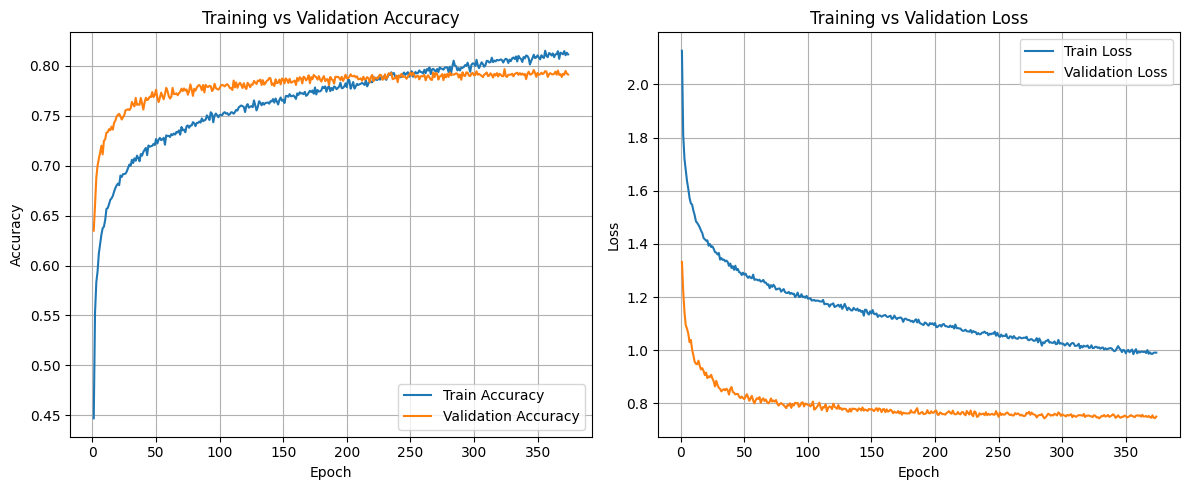

In [97]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_acc_hist) + 1)

plt.figure(figsize=(12, 5))

# =========================
# Accuracy plot
# =========================
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_hist, label="Train Accuracy")
plt.plot(epochs_range, val_acc_hist, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

# =========================
# Loss plot
# =========================
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_hist, label="Train Loss")
plt.plot(epochs_range, val_loss_hist, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [98]:
# =========================
# TEST SET EVALUATION
# =========================
test_loss, test_acc = evaluate(model, X_test_t, y_test_t)

print("=" * 40)
print(f"[FINAL TEST RESULTS]")
print(f"Test Accuracy: {test_acc:.4f}")
print("=" * 40)


[FINAL TEST RESULTS]
Test Accuracy: 0.8034


In [99]:
import numpy as np

model.eval()
with torch.no_grad():
    y_test_logits = model(X_test_t)
    y_test_pred = y_test_logits.argmax(dim=1).cpu().numpy()

y_test_true = y_test_t.cpu().numpy()


In [100]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test_true,
        y_test_pred,
        target_names=class_names
    )
)


              precision    recall  f1-score   support

    airplane       0.64      0.89      0.74       150
       angel       0.82      0.78      0.80       150
       apple       0.94      0.95      0.94       150
      banana       0.93      0.94      0.94       150
     bicycle       0.82      0.91      0.86       150
        bird       0.58      0.58      0.58       150
        book       0.83      0.80      0.82       150
        cake       0.78      0.90      0.83       150
         car       0.79      0.77      0.78       150
         cat       0.79      0.65      0.72       150
       chair       0.87      0.88      0.88       150
      circle       0.96      0.87      0.91       150
       cloud       0.91      0.76      0.83       150
         cup       0.77      0.83      0.80       150
         dog       0.46      0.35      0.40       150
        door       0.81      0.88      0.84       150
    elephant       0.63      0.66      0.64       150
         eye       0.76    

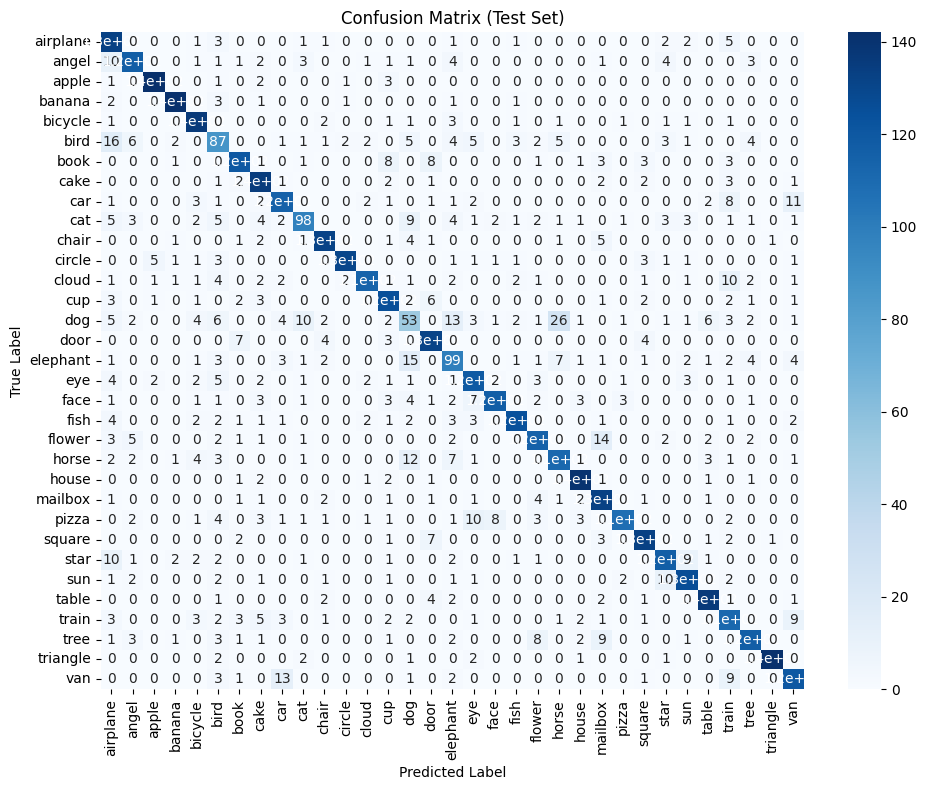

In [104]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test_true, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    annot=True
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


In [102]:
# Find largest off-diagonal confusions
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)

top_confusions = np.dstack(
    np.unravel_index(
        np.argsort(cm_no_diag.ravel())[::-1][:5],
        cm_no_diag.shape
    )
)[0]

print("Top confusions:")
for i, j in top_confusions:
    print(f"{class_names[i]} → {class_names[j]} : {cm[i, j]}")


Top confusions:
dog → horse : 26
bird → airplane : 16
elephant → dog : 15
flower → mailbox : 14
dog → elephant : 13


In [103]:
import joblib

torch.save(model.state_dict(), "quickdraw_mlp.pth")

joblib.dump(scaler, "scaler.pkl")

with open("class_map.json", "w") as f:
    json.dump(class_to_idx, f)